# Utilizzo della libreria Backtester

Questo notebook mostra come utilizzare la libreria di backtesting che abbiamo creato per testare strategie di trading con le Bollinger Bands.

## 1. Importazione delle librerie

In [ ]:
# Importa i moduli della libreria backtester
import sys
sys.path.append('/home/edocame/Desktop/bollingerBands')  # Aggiungi il path

from modules.backtester import data_loader, indicators, backtest_engine, visualization, utils
import pandas as pd
import numpy as np

# Importa anche matplotlib per i grafici
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Caricamento e preparazione dei dati

In [ ]:
# Carica i dati tick dal file Parquet
file_path = '/media/edocame/HDD_2/data_python/03_BID_ASK_DATA/2025.7.16AUDCAD_oanda-TICK-No Session.parquet'
tick_data = data_loader.load_parquet_data(file_path)


print(f"Dati caricati: {len(tick_data)} righe")
print(f"Periodo: {tick_data.index.min()} - {tick_data.index.max()}")
print(f"Colonne: {tick_data.columns.tolist()}")
print("\nPrime righe:")
print(tick_data.head())

In [ ]:
# Rinomina tutte le colonne di minute_data in minuscolo
tick_data.columns = [col.lower() for col in tick_data.columns]
print(f"Colonne rinominate: {tick_data.columns.tolist()}")

In [ ]:
# Assicurati che la colonna 'datetime' sia di tipo datetime e impostala come indice
if not pd.api.types.is_datetime64_any_dtype(tick_data['datetime']):
    tick_data['datetime'] = pd.to_datetime(tick_data['datetime'], errors='coerce')
    print('Colonna datetime convertita in datetime.')
else:
    print('Colonna datetime già in formato datetime.')

# Imposta la colonna 'datetime' come indice
if tick_data.index.name != 'datetime':
    tick_data = tick_data.set_index('datetime')
    print('Colonna datetime impostata come indice.')
else:
    print('Colonna datetime già impostata come indice.')

# Mostra le prime righe per conferma
print(tick_data.head())

In [ ]:
# Prepara i dati a minuto
minute_data = data_loader.prepare_minute_data(tick_data, resample_rule='1T')

print(f"Dati a minuto: {len(minute_data)} righe")
print(f"Periodo: {minute_data.index.min()} - {minute_data.index.max()}")
print("\nPrime righe:")
print(minute_data.head())

In [ ]:
del tick_data
import gc
gc.collect()

## 3. Calcolo degli indicatori tecnici

In [ ]:
# Calcola le Bollinger Bands
window = 1440  # 24 ore = 1440 minuti
num_std_dev = 1.0

data_with_bands = indicators.bollinger_bands(
    minute_data, 
    price_column='midprice',
    window=window, 
    num_std_dev=num_std_dev
)

# Rimuovi le righe con valori NaN
complete_data = data_with_bands.dropna()

print(f"Dati completi per il backtest: {len(complete_data)} righe")
print(f"Colonne disponibili: {complete_data.columns.tolist()}")
print("\nPrime righe con indicatori:")
print(complete_data.head())

## 4. Esecuzione del backtest

In [19]:
# Crea e esegui il backtest
backtester = backtest_engine.Backtest(complete_data)
results_data = backtester.run()

# Stampa il riassunto delle performance
backtester.print_performance_summary()

=== BACKTEST PERFORMANCE SUMMARY ===
Total Trades: 12194
Total PnL: -10236.20 pips
Average Trade: -0.84 pips
Win Rate: 72.60%
Winning Trades: 8853
Losing Trades: 3308
Best Trade: 184.40 pips
Worst Trade: -1280.00 pips
Maximum Drawdown: 11768.20 pips


## 5. Analisi dei risultati

In [20]:
# Ottieni i risultati come DataFrame
trades_df = backtester.get_trades_dataframe()

if not trades_df.empty:
    print(f"Numero di trade: {len(trades_df)}")
    print("\nPrimi 10 trade:")
    print(trades_df.head(10))
    
    # Statistiche aggiuntive
    win_loss_stats = utils.calculate_win_loss_ratio(trades_df['PnL'])
    print("\nStatistiche Win/Loss:")
    for key, value in win_loss_stats.items():
        print(f"  {key}: {value:.2f}")
else:
    print("Nessun trade eseguito.")

Numero di trade: 12194

Primi 10 trade:
    PnL  Direction  Entry_idx  Exit_idx  Cumulative_PnL           Exit_Time
0  11.1         -1         66       386            11.1 2006-01-04 14:31:00
1  13.8         -1        456       547            24.9 2006-01-04 17:20:00
2  14.1         -1        599       836            39.0 2006-01-04 22:34:00
3   9.7         -1        933       942            48.7 2006-01-05 01:19:00
4   6.8         -1       1004      1036            55.5 2006-01-05 03:08:00
5   2.9          1       1043      1057            58.4 2006-01-05 03:32:00
6   0.6         -1       1074      1088            59.0 2006-01-05 04:06:00
7   8.7         -1       1122      1151            67.7 2006-01-05 05:29:00
8   6.2          1       1200      1219            73.9 2006-01-05 07:18:00
9   6.1          1       1266      1308            80.0 2006-01-05 09:23:00

Statistiche Win/Loss:
  win_rate: 72.60
  loss_rate: 27.13
  avg_win: 9.51
  avg_loss: -28.55
  win_loss_ratio: 0.33
  prof

## 7. Grafici interattivi (Plotly)

In [24]:
# Grafico interattivo dei prezzi con Bollinger Bands
visualization.plot_interactive_price_bands(
    subset_data, 
    title="EURCHF con Bollinger Bands - Grafico Interattivo"
)

In [25]:
# Grafico interattivo del PnL cumulativo
if not trades_df.empty:
    visualization.plot_interactive_cumulative_pnl(
        trades_df, 
        title="PnL Cumulativo - Grafico Interattivo"
    )

## 9. Dashboard completo

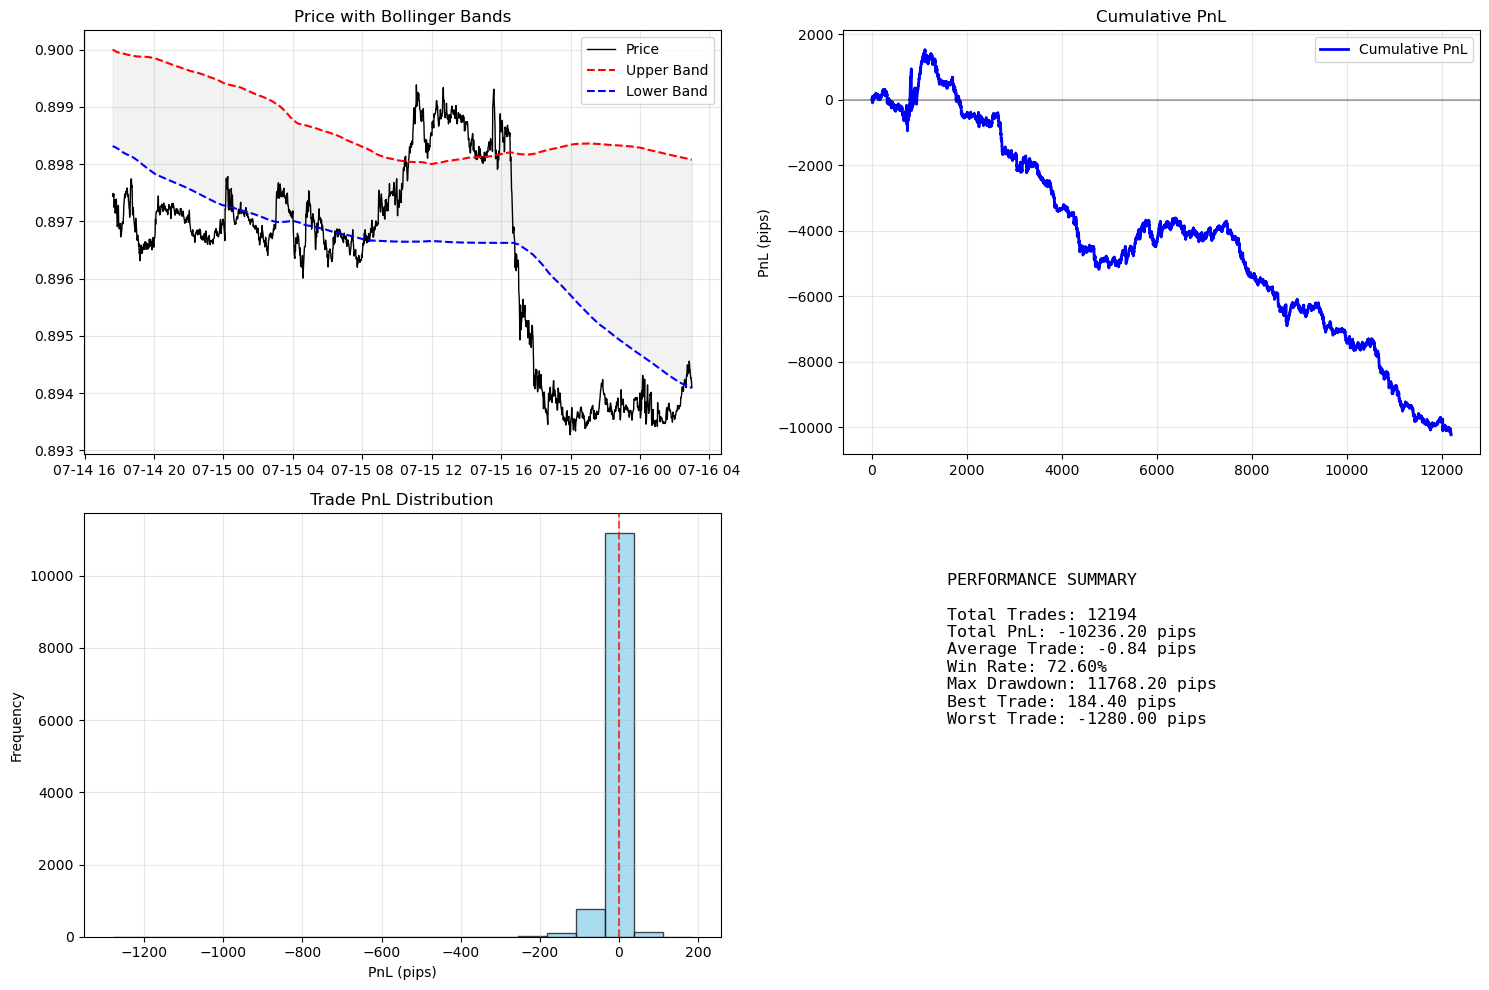

In [26]:
# Crea un dashboard completo con tutti i grafici
if not trades_df.empty:
    visualization.create_performance_dashboard(
        subset_data, 
        trades_df, 
        backtester.performance_metrics
    )

## Analisi dei trade in base all'ora

In [29]:
# Analisi delle statistiche dei trade in base all'ora del giorno e giorno della settimana
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

if not trades_df.empty:
    # Prepara i dati per l'analisi temporale
    trades_analysis = trades_df.copy()
    
    # Calcola l'Entry_Time utilizzando l'indice Entry_idx e i dati originali
    trades_analysis['Entry_Time'] = complete_data.index[trades_analysis['Entry_idx']]
    
    # Aggiungi colonne per l'analisi temporale basate su Entry_Time
    trades_analysis['entry_hour'] = trades_analysis['Entry_Time'].dt.hour
    trades_analysis['entry_day_of_week'] = trades_analysis['Entry_Time'].dt.day_name()
    trades_analysis['entry_day_of_week_num'] = trades_analysis['Entry_Time'].dt.dayofweek
    
    # Aggiungi colonne per l'analisi temporale basate su Exit_Time
    trades_analysis['exit_hour'] = trades_analysis['Exit_Time'].dt.hour
    trades_analysis['exit_day_of_week'] = trades_analysis['Exit_Time'].dt.day_name()
    trades_analysis['exit_day_of_week_num'] = trades_analysis['Exit_Time'].dt.dayofweek
    
    # Calcola durata del trade in minuti
    trades_analysis['trade_duration_minutes'] = (trades_analysis['Exit_Time'] - trades_analysis['Entry_Time']).dt.total_seconds() / 60
    
    # Aggiungi metriche di performance
    trades_analysis['is_winner'] = trades_analysis['PnL'] > 0
    trades_analysis['abs_pnl'] = trades_analysis['PnL'].abs()
    trades_analysis['is_long'] = trades_analysis['Direction'] == 1
    trades_analysis['is_short'] = trades_analysis['Direction'] == -1
    
    print("=== ANALISI TRADE COMPLETATA ===")
    print(f"Dati di analisi preparati con {len(trades_analysis)} trade")
    print(f"Periodo analizzato: {trades_analysis['Entry_Time'].min()} - {trades_analysis['Exit_Time'].max()}")
    print(f"Nuove colonne create: {[col for col in trades_analysis.columns if col not in trades_df.columns]}")
    
    # Statistiche per ora del giorno (Entry)
    hourly_entry_stats = trades_analysis.groupby('entry_hour').agg({
        'PnL': ['count', 'mean', 'sum', 'std'],
        'is_winner': 'mean',
        'abs_pnl': 'mean',
        'trade_duration_minutes': 'mean'
    }).round(4)
    
    # Flatten column names
    hourly_entry_stats.columns = ['_'.join(col).strip() for col in hourly_entry_stats.columns.values]
    hourly_entry_stats = hourly_entry_stats.reset_index()
    
    # Statistiche per giorno della settimana (Entry)
    daily_entry_stats = trades_analysis.groupby(['entry_day_of_week', 'entry_day_of_week_num']).agg({
        'PnL': ['count', 'mean', 'sum', 'std'],
        'is_winner': 'mean',
        'abs_pnl': 'mean',
        'trade_duration_minutes': 'mean'
    }).round(4)
    
    # Flatten column names
    daily_entry_stats.columns = ['_'.join(col).strip() for col in daily_entry_stats.columns.values]
    daily_entry_stats = daily_entry_stats.reset_index().sort_values('entry_day_of_week_num')
    
    print("\n=== STATISTICHE PER ORA DI ENTRATA ===")
    print(hourly_entry_stats[['entry_hour', 'PnL_count', 'PnL_mean', 'PnL_sum', 'is_winner_mean', 'trade_duration_minutes_mean']].to_string(index=False))
    
    print("\n=== STATISTICHE PER GIORNO DELLA SETTIMANA (ENTRATA) ===")
    print(daily_entry_stats[['entry_day_of_week', 'PnL_count', 'PnL_mean', 'PnL_sum', 'is_winner_mean', 'trade_duration_minutes_mean']].to_string(index=False))
    
else:
    print("Nessun trade disponibile per l'analisi temporale.")

=== ANALISI TRADE COMPLETATA ===
Dati di analisi preparati con 12194 trade
Periodo analizzato: 2006-01-04 08:19:00 - 2025-07-16 02:59:00
Nuove colonne create: ['Entry_Time', 'entry_hour', 'entry_day_of_week', 'entry_day_of_week_num', 'exit_hour', 'exit_day_of_week', 'exit_day_of_week_num', 'trade_duration_minutes', 'is_winner', 'abs_pnl', 'is_long', 'is_short']

=== STATISTICHE PER ORA DI ENTRATA ===
 entry_hour  PnL_count  PnL_mean  PnL_sum  is_winner_mean  trade_duration_minutes_mean
          0        455   -0.0651    -29.6          0.6022                     408.2725
          1        284    0.9504    269.9          0.7852                     407.8310
          2        444    0.4863    215.9          0.7545                     493.3604
          3        559   -1.1850   -662.4          0.7549                     498.7764
          4        627   -3.9330  -2466.0          0.7177                     763.9665
          5        424   -2.5146  -1066.2          0.7217                 

In [30]:
if not trades_df.empty:
    # 1. Heatmap del PnL medio per ora di entrata e giorno della settimana
    pivot_data = trades_analysis.groupby(['entry_day_of_week_num', 'entry_hour'])['PnL'].mean().reset_index()
    pivot_matrix = pivot_data.pivot(index='entry_day_of_week_num', columns='entry_hour', values='PnL')
    
    # Sostituisci i numeri dei giorni con i nomi
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    pivot_matrix.index = [day_names[i] if i < len(day_names) else f'Day_{i}' for i in pivot_matrix.index]
    
    fig_heatmap = go.Figure(data=go.Heatmap(
        z=pivot_matrix.values,
        x=pivot_matrix.columns,
        y=pivot_matrix.index,
        colorscale='RdYlGn',
        colorbar=dict(title="Average PnL"),
        hoverongaps=False,
        text=pivot_matrix.values.round(2),
        texttemplate="%{text}",
        textfont={"size": 10}
    ))
    
    fig_heatmap.update_layout(
        title="Heatmap: PnL Medio per Ora di Entrata e Giorno della Settimana",
        xaxis_title="Ora di Entrata",
        yaxis_title="Giorno della Settimana",
        height=400
    )
    
    fig_heatmap.show()
    
    # 2. Grafici multipli con subplots
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('PnL per Ora di Entrata', 'Win Rate per Ora di Entrata', 
                       'PnL per Giorno della Settimana', 'Durata Media Trade'),
        specs=[[{"secondary_y": True}, {"secondary_y": False}],
               [{"secondary_y": True}, {"secondary_y": False}]]
    )
    
    # Subplot 1: PnL per ora (bar + line per win rate)
    fig.add_trace(
        go.Bar(x=hourly_entry_stats['entry_hour'], y=hourly_entry_stats['PnL_sum'], 
               name='PnL Totale', marker_color='lightblue'),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=hourly_entry_stats['entry_hour'], y=hourly_entry_stats['is_winner_mean'], 
                   mode='lines+markers', name='Win Rate', line=dict(color='red')),
        row=1, col=1, secondary_y=True
    )
    
    # Subplot 2: Win rate per ora
    fig.add_trace(
        go.Bar(x=hourly_entry_stats['entry_hour'], y=hourly_entry_stats['is_winner_mean'], 
               name='Win Rate Oraria', marker_color='green'),
        row=1, col=2
    )
    
    # Subplot 3: PnL per giorno della settimana
    fig.add_trace(
        go.Bar(x=daily_entry_stats['entry_day_of_week'], y=daily_entry_stats['PnL_sum'], 
               name='PnL per Giorno', marker_color='orange'),
        row=2, col=1
    )
    fig.add_trace(
        go.Scatter(x=daily_entry_stats['entry_day_of_week'], y=daily_entry_stats['is_winner_mean'], 
                   mode='lines+markers', name='Win Rate Giornaliera', line=dict(color='purple')),
        row=2, col=1, secondary_y=True
    )
    
    # Subplot 4: Durata media trade per giorno
    fig.add_trace(
        go.Bar(x=daily_entry_stats['entry_day_of_week'], y=daily_entry_stats['trade_duration_minutes_mean'], 
               name='Durata Media (min)', marker_color='lightcoral'),
        row=2, col=2
    )
    
    # Update layout
    fig.update_layout(
        title_text="Analisi Completa delle Performance Temporali",
        showlegend=True,
        height=800
    )
    
    # Update y-axes titles
    fig.update_yaxes(title_text="PnL Totale", row=1, col=1)
    fig.update_yaxes(title_text="Win Rate", row=1, col=1, secondary_y=True)
    fig.update_yaxes(title_text="Win Rate", row=1, col=2)
    fig.update_yaxes(title_text="PnL Totale", row=2, col=1)
    fig.update_yaxes(title_text="Win Rate", row=2, col=1, secondary_y=True)
    fig.update_yaxes(title_text="Durata (min)", row=2, col=2)
    
    fig.show()
    
    # 3. Box plot del PnL per ora di entrata
    fig_box_hour = px.box(trades_analysis, x='entry_hour', y='PnL', 
                          title='Distribuzione PnL per Ora di Entrata',
                          labels={'entry_hour': 'Ora di Entrata', 'PnL': 'Profit/Loss'})
    fig_box_hour.show()
    
    # 4. Box plot del PnL per giorno della settimana
    fig_box_day = px.box(trades_analysis, x='entry_day_of_week', y='PnL',
                         category_orders={'entry_day_of_week': day_names},
                         title='Distribuzione PnL per Giorno della Settimana (Entrata)',
                         labels={'entry_day_of_week': 'Giorno della Settimana', 'PnL': 'Profit/Loss'})
    fig_box_day.show()
    
    # 5. Scatter plot: Relazione tra ora di entrata e PnL
    fig_scatter = px.scatter(trades_analysis, x='entry_hour', y='PnL', color='entry_day_of_week',
                            size='trade_duration_minutes',
                            title='Relazione tra Ora di Entrata, PnL e Durata Trade',
                            labels={'entry_hour': 'Ora di Entrata', 'PnL': 'Profit/Loss'},
                            category_orders={'entry_day_of_week': day_names})
    fig_scatter.show()
    
    # 6. Analisi Long vs Short per ora del giorno
    long_short_hourly = trades_analysis.groupby(['entry_hour', 'is_long']).agg({
        'PnL': ['count', 'mean', 'sum'],
        'is_winner': 'mean'
    }).round(4)
    
    long_short_hourly.columns = ['_'.join(col).strip() for col in long_short_hourly.columns.values]
    long_short_hourly = long_short_hourly.reset_index()
    
    fig_long_short = go.Figure()
    
    # Trade Long
    long_data = long_short_hourly[long_short_hourly['is_long'] == True]
    fig_long_short.add_trace(go.Bar(
        x=long_data['entry_hour'],
        y=long_data['PnL_sum'],
        name='Long Trades',
        marker_color='green',
        opacity=0.7
    ))
    
    # Trade Short
    short_data = long_short_hourly[long_short_hourly['is_long'] == False]
    fig_long_short.add_trace(go.Bar(
        x=short_data['entry_hour'],
        y=short_data['PnL_sum'],
        name='Short Trades',
        marker_color='red',
        opacity=0.7
    ))
    
    fig_long_short.update_layout(
        title='PnL per Ora: Confronto Long vs Short Trades',
        xaxis_title='Ora di Entrata',
        yaxis_title='PnL Totale',
        barmode='group'
    )
    fig_long_short.show()
    
    # 7. Heatmap della Win Rate per ora e giorno
    pivot_winrate = trades_analysis.groupby(['entry_day_of_week_num', 'entry_hour'])['is_winner'].mean().reset_index()
    pivot_winrate_matrix = pivot_winrate.pivot(index='entry_day_of_week_num', columns='entry_hour', values='is_winner')
    pivot_winrate_matrix.index = [day_names[i] if i < len(day_names) else f'Day_{i}' for i in pivot_winrate_matrix.index]
    
    fig_winrate_heatmap = go.Figure(data=go.Heatmap(
        z=pivot_winrate_matrix.values * 100,  # Convert to percentage
        x=pivot_winrate_matrix.columns,
        y=pivot_winrate_matrix.index,
        colorscale='RdYlGn',
        colorbar=dict(title="Win Rate (%)"),
        text=np.round(pivot_winrate_matrix.values * 100, 1),
        texttemplate="%{text}%",
        textfont={"size": 10}
    ))
    
    fig_winrate_heatmap.update_layout(
        title="Heatmap: Win Rate (%) per Ora di Entrata e Giorno della Settimana",
        xaxis_title="Ora di Entrata",
        yaxis_title="Giorno della Settimana",
        height=400
    )
    
    fig_winrate_heatmap.show()
    
    print("\n=== STATISTICHE RIASSUNTIVE ===")
    print(f"Migliore ora per PnL medio: {hourly_entry_stats.loc[hourly_entry_stats['PnL_mean'].idxmax(), 'entry_hour']}:00")
    print(f"Migliore giorno per PnL totale: {daily_entry_stats.loc[daily_entry_stats['PnL_sum'].idxmax(), 'entry_day_of_week']}")
    print(f"Migliore ora per Win Rate: {hourly_entry_stats.loc[hourly_entry_stats['is_winner_mean'].idxmax(), 'entry_hour']}:00")
    print(f"Migliore giorno per Win Rate: {daily_entry_stats.loc[daily_entry_stats['is_winner_mean'].idxmax(), 'entry_day_of_week']}")
    
else:
    print("Nessun trade disponibile per l'analisi temporale.")


=== STATISTICHE RIASSUNTIVE ===
Migliore ora per PnL medio: 23:00
Migliore giorno per PnL totale: Friday
Migliore ora per Win Rate: 1:00
Migliore giorno per Win Rate: Wednesday


In [32]:
# Analisi aggiuntive e tabelle riassuntive
if not trades_df.empty:
    print("=== ANALISI DETTAGLIATA DELLE PERFORMANCE TEMPORALI ===\n")
    
    # 1. Confronto sessioni di trading
    trades_analysis['trading_session'] = trades_analysis['entry_hour'].apply(
        lambda x: 'Asian' if 0 <= x < 8 else 
                 'European' if 8 <= x < 16 else 
                 'American' if 16 <= x < 24 else 'Other'
    )
    
    session_stats = trades_analysis.groupby('trading_session').agg({
        'PnL': ['count', 'mean', 'sum', 'std'],
        'is_winner': 'mean',
        'trade_duration_minutes': 'mean'
    }).round(4)
    
    session_stats.columns = ['_'.join(col).strip() for col in session_stats.columns.values]
    session_stats = session_stats.reset_index()
    
    print("1. PERFORMANCE PER SESSIONE DI TRADING:")
    print(session_stats.to_string(index=False))
    
    # 2. Analisi weekend vs weekdays
    trades_analysis['is_weekend'] = trades_analysis['entry_day_of_week_num'].isin([5, 6])
    
    weekend_stats = trades_analysis.groupby('is_weekend').agg({
        'PnL': ['count', 'mean', 'sum'],
        'is_winner': 'mean',
        'trade_duration_minutes': 'mean'
    }).round(4)
    
    weekend_stats.columns = ['_'.join(col).strip() for col in weekend_stats.columns.values]
    weekend_stats = weekend_stats.reset_index()
    weekend_stats['period'] = weekend_stats['is_weekend'].map({True: 'Weekend', False: 'Weekdays'})
    
    print("\n2. PERFORMANCE WEEKEND vs WEEKDAYS:")
    print(weekend_stats[['period', 'PnL_count', 'PnL_mean', 'PnL_sum', 'is_winner_mean']].to_string(index=False))
    
    # 3. Top e bottom performance per ora
    top_hours = hourly_entry_stats.nlargest(3, 'PnL_mean')[['entry_hour', 'PnL_mean', 'is_winner_mean', 'PnL_count']]
    bottom_hours = hourly_entry_stats.nsmallest(3, 'PnL_mean')[['entry_hour', 'PnL_mean', 'is_winner_mean', 'PnL_count']]
    
    print("\n3. TOP 3 ORE PER PnL MEDIO:")
    print(top_hours.to_string(index=False))
    
    print("\nBOTTOM 3 ORE PER PnL MEDIO:")
    print(bottom_hours.to_string(index=False))
    
    # 4. Analisi volatilità per ora (deviazione standard del PnL)
    volatility_by_hour = trades_analysis.groupby('entry_hour')['PnL'].std().reset_index()
    volatility_by_hour.columns = ['entry_hour', 'pnl_volatility']
    volatility_by_hour = volatility_by_hour.sort_values('pnl_volatility', ascending=False)
    
    print("\n4. VOLATILITÀ PnL PER ORA (Top 5):")
    print(volatility_by_hour.head().to_string(index=False))
    
    # 5. Risk-Return ratio per ora (PnL medio / volatilità)
    risk_return = hourly_entry_stats.merge(volatility_by_hour, on='entry_hour')
    risk_return['risk_return_ratio'] = risk_return['PnL_mean'] / risk_return['pnl_volatility']
    risk_return = risk_return.sort_values('risk_return_ratio', ascending=False)
    
    print("\n5. MIGLIORI ORE PER RISK-RETURN RATIO (Top 5):")
    print(risk_return[['entry_hour', 'PnL_mean', 'pnl_volatility', 'risk_return_ratio']].head().to_string(index=False))
    
    # 6. Grafico delle sessioni di trading
    fig_sessions = px.bar(session_stats, x='trading_session', y='PnL_sum',
                         title='Performance per Sessione di Trading',
                         labels={'PnL_sum': 'PnL Totale', 'trading_session': 'Sessione'},
                         color='PnL_sum', color_continuous_scale='RdYlGn')
    fig_sessions.show()
    
    # 7. Grafico comparativo weekend vs weekdays (con controllo errori)
    try:
        fig_weekend = go.Figure()
        
        weekdays_data = weekend_stats[weekend_stats['period'] == 'Weekdays']
        weekend_data = weekend_stats[weekend_stats['period'] == 'Weekend']
        
        if not weekdays_data.empty:
            fig_weekend.add_trace(go.Bar(
                x=['Numero Trade', 'PnL Medio', 'Win Rate'],
                y=[weekdays_data['PnL_count'].iloc[0],
                   weekdays_data['PnL_mean'].iloc[0],
                   weekdays_data['is_winner_mean'].iloc[0]],
                name='Weekdays',
                marker_color='blue'
            ))
        
        if not weekend_data.empty:
            fig_weekend.add_trace(go.Bar(
                x=['Numero Trade', 'PnL Medio', 'Win Rate'],
                y=[weekend_data['PnL_count'].iloc[0],
                   weekend_data['PnL_mean'].iloc[0],
                   weekend_data['is_winner_mean'].iloc[0]],
                name='Weekend',
                marker_color='orange'
            ))
        
        fig_weekend.update_layout(
            title='Confronto Performance: Weekdays vs Weekend',
            barmode='group',
            yaxis_title='Valore'
        )
        fig_weekend.show()
        
    except Exception as e:
        print(f"\nNota: Impossibile creare il grafico weekend vs weekdays - {e}")
        print("Possibili cause: dati insufficienti per weekend o struttura dati diversa.")
    
    print("\n=== RACCOMANDAZIONI STRATEGICHE ===")
    best_hour = hourly_entry_stats.loc[hourly_entry_stats['PnL_mean'].idxmax(), 'entry_hour']
    best_day = daily_entry_stats.loc[daily_entry_stats['PnL_sum'].idxmax(), 'entry_day_of_week']
    best_session = session_stats.loc[session_stats['PnL_mean'].idxmax(), 'trading_session']
    
    print(f"• Concentrare i trade nell'ora: {best_hour}:00")
    print(f"• Giorno più profittevole: {best_day}")
    print(f"• Sessione di trading più efficace: {best_session}")
    print(f"• Evitare le ore con PnL negativo: {bottom_hours['entry_hour'].tolist()}")
    
    worst_day = daily_entry_stats.loc[daily_entry_stats['PnL_sum'].idxmin(), 'entry_day_of_week']
    print(f"• Prestare attenzione nei giorni meno profittevoli: {worst_day}")
    
    # Statistiche aggiuntive sui giorni di trading
    unique_days = trades_analysis['entry_day_of_week_num'].unique()
    print(f"\n• Giorni della settimana con trade: {sorted(unique_days)}")
    if 5 not in unique_days and 6 not in unique_days:
        print("• Nota: Nessun trade nel weekend (Sabato=5, Domenica=6)")
    
else:
    print("Nessun trade disponibile per l'analisi.")

=== ANALISI DETTAGLIATA DELLE PERFORMANCE TEMPORALI ===

1. PERFORMANCE PER SESSIONE DI TRADING:
trading_session  PnL_count  PnL_mean  PnL_sum  PnL_std  is_winner_mean  trade_duration_minutes_mean
       American       4186   -0.7530  -3152.0  25.8553          0.7090                     829.7004
          Asian       3437   -1.4474  -4974.8  34.3405          0.7198                     556.6974
       European       4571   -0.4615  -2109.4  25.9333          0.7462                     627.3704

2. PERFORMANCE WEEKEND vs WEEKDAYS:
  period  PnL_count  PnL_mean  PnL_sum  is_winner_mean
Weekdays      12194   -0.8394 -10236.2           0.726

3. TOP 3 ORE PER PnL MEDIO:
 entry_hour  PnL_mean  is_winner_mean  PnL_count
         23    1.8133          0.6749        323
          8    1.4403          0.7806        392
         10    1.0491          0.7636        605

BOTTOM 3 ORE PER PnL MEDIO:
 entry_hour  PnL_mean  is_winner_mean  PnL_count
          4   -3.9330          0.7177        627
    


=== RACCOMANDAZIONI STRATEGICHE ===
• Concentrare i trade nell'ora: 23:00
• Giorno più profittevole: Friday
• Sessione di trading più efficace: European
• Evitare le ore con PnL negativo: [4, 6, 5]
• Prestare attenzione nei giorni meno profittevoli: Tuesday

• Giorni della settimana con trade: [0, 1, 2, 3, 4]
• Nota: Nessun trade nel weekend (Sabato=5, Domenica=6)


## 10. Test con parametri diversi

In [ ]:
# Forza il reload del modulo per assicurarsi che le nuove funzioni siano disponibili
import importlib
import sys

# Reload del modulo backtest_engine per caricare le nuove funzioni
if 'backtester.backtest_engine' in sys.modules:
    importlib.reload(sys.modules['backtester.backtest_engine'])

# Importa le funzioni di ottimizzazione dal backtest_engine
from modules.backtester.backtest_engine import optimize_parameters, plot_top_equity_curves

# Esegui l'ottimizzazione dei parametri con multiprocessing
print("Avvio ottimizzazione parametri...")
parameter_results = optimize_parameters(
    minute_data=minute_data,
    window_start=60,
    window_stop=14400,
    window_step=60,
    std_start=0.2,
    std_stop=4.0,
    std_step=0.2,
    price_column='midprice'
)

# Mostra i risultati completi
print("\n=== TUTTI I RISULTATI ===")
print(parameter_results.to_string(index=False))

# Plotta le top 5 equity curves usando la funzione dedicata
print("\nGenerazione grafici delle migliori equity curves...")
plot_top_equity_curves(
    results_df=parameter_results,
    minute_data=minute_data,
    top_n=5,
    price_column='midprice'
)

## Walk forward opt

In [ ]:
# Crea un subset di minute_data in base a start_date e end_date
start_date = '2023-01-01'
end_date = '2025-07-05'
subset_df = minute_data.loc[start_date:end_date]

print(f"Subset creato: {len(subset_df)} righe")
print(f"Periodo: {subset_df.index.min()} - {subset_df.index.max()}")
print(subset_df.head())

In [ ]:
# Force reload of the modules to ensure latest changes are loaded
import importlib
import sys

# Reload all backtester modules
modules_to_reload = [
    'modules.backtester.walk_forward',
    'modules.backtester.backtest_engine',
    'modules.backtester.indicators',
    'modules.backtester.data_loader',
    'modules.backtester.visualization',
    'modules.backtester.utils'
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        importlib.reload(sys.modules[module_name])

# Re-import the walk forward functions with the fixes
from modules.backtester.walk_forward import walk_forward_optimization, plot_wfo_results

# Execute Walk Forward Optimization with proper error handling
try:
    print("Starting Walk Forward Optimization...")
    wfo_results = walk_forward_optimization(
        minute_data=subset_df,
        lookback_days=180,  # Use 10 days of data for optimization
        optimization_interval_days=5,  # Re-optimize every 5 days
        window_start=400,
        window_stop=8000,
        window_step=1000,
        std_start=0.5,
        std_stop=6.0,
        std_step=0.5,
        price_column='midprice'
    )
    
    # Plot and analyze results
    plot_wfo_results(wfo_results)
    
except Exception as e:
    print(f"Error during Walk Forward Optimization: {e}")
    import traceback
    traceback.print_exc()
    print("Please check your data and parameters.")